In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Prueba con XGBoost

In [2]:
# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp1"

# Buscar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(ruta, "*.csv"))

# Leer y concatenar
df = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv), ignore_index=True)

# Features y target
X = df[["D", "A", "B", "x", "y"]] 
y = df["fitness"]

df.describe()

,D,A,B,x,y,fitness
count,870000.000000,870000.000000,870000.000000,870000.000000,870000.000000,870000.000000
mean,23.375038,0.000102,12.311822,413.653282,592.561775,0.242309
std,12.553548,0.000066,3.794251,21.404564,24.059357,0.213932
min,0.010000,0.000000,0.000000,350.000000,450.000000,0.012355
25%,16.597178,0.000068,10.509581,407.000000,592.000000,0.086255
50%,19.451534,0.000082,13.254744,410.000000,597.000000,0.176660
75%,26.911060,0.000121,14.660036,416.000000,600.000000,0.327863
max,100.000000,0.000562,23.609983,538.000000,651.000000,2.390712


In [3]:
# ---------------------------
# 2. Train / Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
# ---------------------------
# 3. Entrenar modelo XGBoost
# ---------------------------
model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method="hist",   # GPU
    device="cuda",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [5]:
# ---------------------------
# 4. Evaluar surrogate
# ---------------------------
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.6f}")

c:\Users\becer\miniconda3\envs\pinns\Lib\site-packages\xgboost\core.py:729: UserWarning: [12:26:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


MSE: 0.000122
R²: 0.997302


In [6]:
from sklearn.model_selection import cross_val_score, KFold

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar R²
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print("R² promedio:", np.mean(r2_scores), "+/-", np.std(r2_scores))
print("MSE promedio:", -np.mean(mse_scores), "+/-", np.std(mse_scores))

KeyboardInterrupt: 

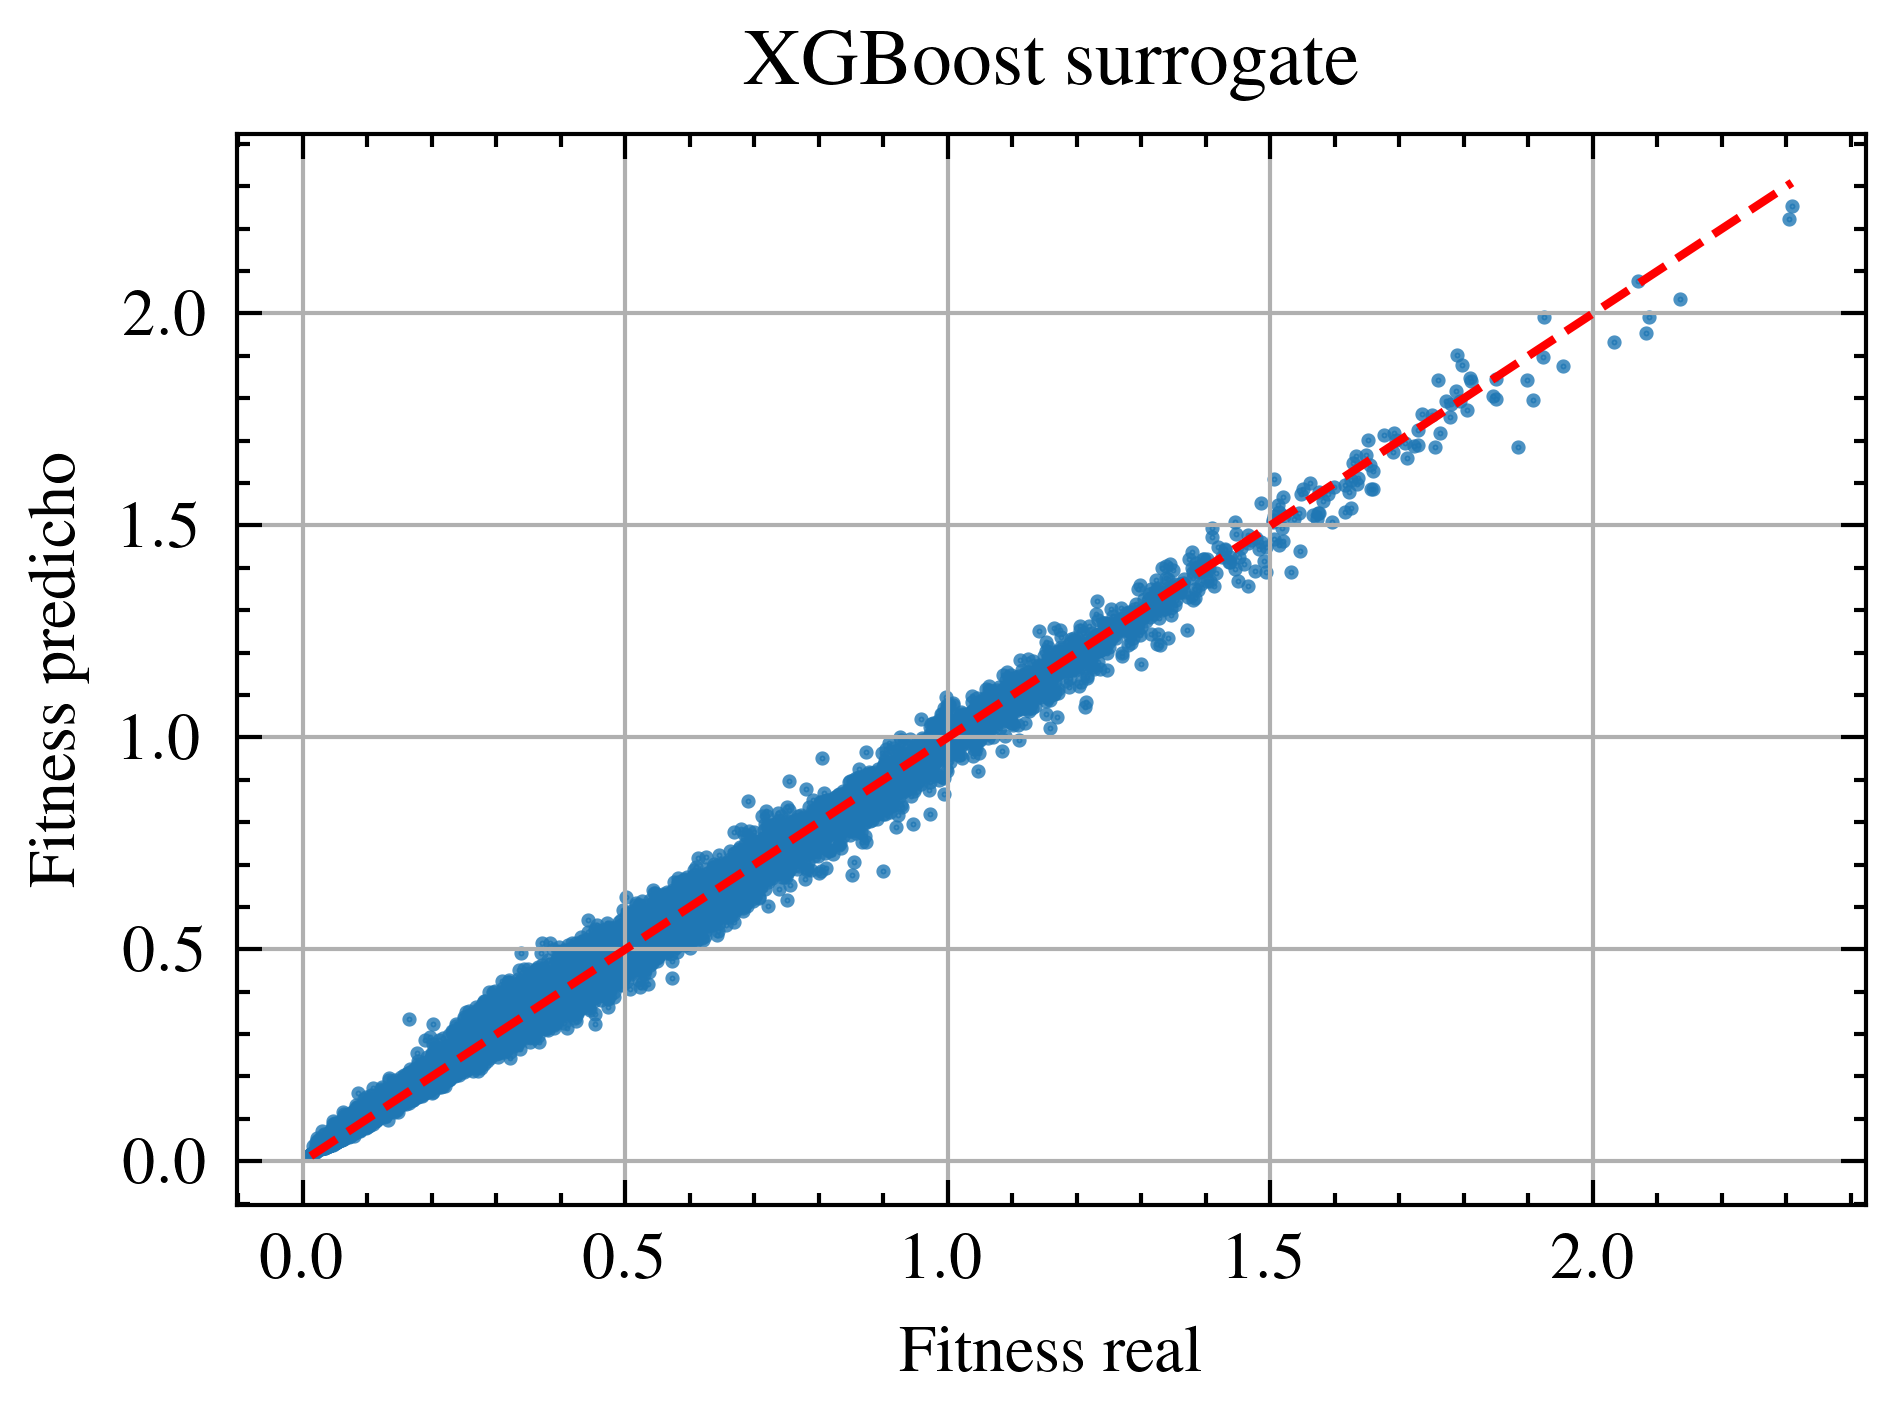

In [74]:
import scienceplots
# ---------------------------
# 5. Visualización: real vs predicho
plt.style.use(["science", "ieee"])  # activás scienceplots
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)  # ciclo estándar matplotlib

# ---------------------------
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.8, s=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Fitness real")
plt.ylabel("Fitness predicho")
# plt.xlim(0, 0.1)
# plt.ylim(0, 0.1)
plt.title("XGBoost surrogate")
plt.grid()
plt.tight_layout()
plt.savefig("XGBoost_test.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# ---------------------------
# 6. Usar surrogate para explorar
# ---------------------------
# Ejemplo: generar 100,000 combinaciones aleatorias en el rango
# Rango de parámetros según tu dataframe
param_ranges = {
    "D": (df["D"].min(), df["D"].max()),
    "A": (df["A"].min(), df["A"].max()),
    "B": (df["B"].min(), df["B"].max()),
    "x": (df["x"].min(), df["x"].max()),
    "y": (df["y"].min(), df["y"].max()),
}

# Configuración de la búsqueda
N_total = int(4e8)       # total de candidatos a probar (200 millones)
batch_size = int(1e6)    # tamaño del batch (1 millón)
n_batches = N_total // batch_size

k = 20  # top-k por batch
mejores_globales = []

for i in range(n_batches):
    print(f"Batch {i+1}/{n_batches}")

    # Generar candidatos aleatorios dentro de los rangos
    candidatos = np.column_stack([
        np.random.uniform(low, high, batch_size)
        for (low, high) in param_ranges.values()
    ])

    # Predecir fitness con el surrogate model
    preds = model.predict(candidatos)

    # Obtener los mejores índices (menor fitness = mejor)
    top_idx = np.argsort(preds)[:k]

    # Guardar pares (parámetros, fitness)
    for idx in top_idx:
        mejores_globales.append((candidatos[idx], preds[idx]))

# Convertir a array y seleccionar los mejores globales
mejores_globales = sorted(mejores_globales, key=lambda x: x[1])[:50]

# Separar parámetros y fitness
candidatos_finales = np.array([x[0] for x in mejores_globales])
fitness_finales = np.array([x[1] for x in mejores_globales])

print("Top candidatos encontrados:")
for i, (params, fit) in enumerate(zip(candidatos_finales, fitness_finales), 1):
    print(f"{i}: {params}, fitness={fit}")

Batch 1/400
Batch 2/400
Batch 3/400
Batch 4/400
Batch 5/400
Batch 6/400
Batch 7/400
Batch 8/400
Batch 9/400
Batch 10/400
Batch 11/400
Batch 12/400
Batch 13/400
Batch 14/400
Batch 15/400
Batch 16/400
Batch 17/400
Batch 18/400
Batch 19/400
Batch 20/400
Batch 21/400
Batch 22/400
Batch 23/400
Batch 24/400
Batch 25/400
Batch 26/400
Batch 27/400
Batch 28/400
Batch 29/400
Batch 30/400
Batch 31/400
Batch 32/400
Batch 33/400
Batch 34/400
Batch 35/400
Batch 36/400
Batch 37/400
Batch 38/400
Batch 39/400
Batch 40/400
Batch 41/400
Batch 42/400
Batch 43/400
Batch 44/400
Batch 45/400
Batch 46/400
Batch 47/400
Batch 48/400
Batch 49/400
Batch 50/400
Batch 51/400
Batch 52/400
Batch 53/400
Batch 54/400
Batch 55/400
Batch 56/400
Batch 57/400
Batch 58/400
Batch 59/400
Batch 60/400
Batch 61/400
Batch 62/400
Batch 63/400
Batch 64/400
Batch 65/400
Batch 66/400
Batch 67/400
Batch 68/400
Batch 69/400
Batch 70/400
Batch 71/400
Batch 72/400
Batch 73/400
Batch 74/400
Batch 75/400
Batch 76/400
Batch 77/400
Batch 78

Mejor parámetro encontrado:
[15.275642262646764, 6.85490545873527e-05, 15.082002216393414, np.int64(407), np.int64(596)]
Fitness estimado: 0.031220451


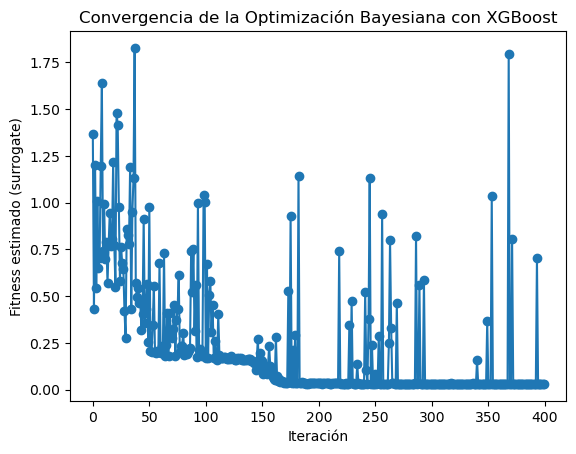

In [10]:
# --- 3. Definir el espacio de búsqueda ---
space = [
    Real(df["D"].min(), df["D"].max(), name="D"),
    Real(df["A"].min(), df["A"].max(), name="A"),
    Real(df["B"].min(), df["B"].max(), name="B"),
    Integer(df["x"].min(), df["x"].max(), name="x"),
    Integer(df["y"].min(), df["y"].max(), name="y"),
]

# --- 4. Función objetivo (usa surrogate XGBoost) ---
@use_named_args(space)
def objective(**params):
    x_input = np.array([[params["D"], params["A"], params["B"], params["x"], params["y"]]])
    return model.predict(x_input)[0]

# --- 5. Ejecutar optimización bayesiana ---
res = gp_minimize(
    objective,
    space,
    n_calls=400,          # número de iteraciones (ajustar según quieras)
    n_random_starts=40,  # arranca con puntos aleatorios
    random_state=0
)

# --- 6. Resultados ---
print("Mejor parámetro encontrado:")
print(res.x)
print("Fitness estimado:", res.fun)

# --- 7. Convergencia ---
plt.plot(res.func_vals, marker="o")
plt.xlabel("Iteración")
plt.ylabel("Fitness estimado (surrogate)")
plt.title("Convergencia de la Optimización Bayesiana con XGBoost")
plt.show()

# Surrogate con Redes Neuronales

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Preparar datos ---
X = df[["D", "A", "B", "x", "y"]].values
y = df["fitness"].values.reshape(-1, 1)

# Escalamos para mejorar entrenamiento
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=0
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

In [42]:
# --- 2. Definir surrogate NN ---
class SurrogateNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = SurrogateNN().to(device)

In [43]:
# --- 3. Entrenamiento ---
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2000):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        val_loss = loss_fn(model(X_val), y_val).item()
        print(f"Epoch {epoch+1}, Train Loss={loss.item():.8f}, Val Loss={val_loss:.8f}")

Epoch 20, Train Loss=0.00920415, Val Loss=0.00878222
Epoch 40, Train Loss=0.00523130, Val Loss=0.00494242
Epoch 60, Train Loss=0.00238310, Val Loss=0.00229917
Epoch 80, Train Loss=0.00143880, Val Loss=0.00138442
Epoch 100, Train Loss=0.00070486, Val Loss=0.00067871
Epoch 120, Train Loss=0.00036666, Val Loss=0.00035269
Epoch 140, Train Loss=0.00022919, Val Loss=0.00022252
Epoch 160, Train Loss=0.00017911, Val Loss=0.00017384
Epoch 180, Train Loss=0.00015228, Val Loss=0.00014851
Epoch 200, Train Loss=0.00013540, Val Loss=0.00013219
Epoch 220, Train Loss=0.00012524, Val Loss=0.00012166
Epoch 240, Train Loss=0.00011652, Val Loss=0.00011388
Epoch 260, Train Loss=0.00012294, Val Loss=0.00011419
Epoch 280, Train Loss=0.00010460, Val Loss=0.00010380
Epoch 300, Train Loss=0.00009958, Val Loss=0.00009805
Epoch 320, Train Loss=0.00009513, Val Loss=0.00009361
Epoch 340, Train Loss=0.00009998, Val Loss=0.00010562
Epoch 360, Train Loss=0.00008780, Val Loss=0.00008813
Epoch 380, Train Loss=0.00008443

In [44]:
# --- 4. Optimización directa sobre parámetros ---
# Empezamos desde un punto inicial (ej: promedio de datos)
theta = torch.tensor(np.mean(X_scaled, axis=0), dtype=torch.float32, requires_grad=True, device=device)

opt_theta = optim.Adam([theta], lr=1e-2)

for step in range(3000):
    pred_fitness = model(theta)
    opt_theta.zero_grad()
    pred_fitness.backward()
    opt_theta.step()
    if (step+1) % 50 == 0:
        print(f"Step {step+1}, Fitness (scaled)={pred_fitness.item():.4f}")

Step 50, Fitness (scaled)=0.0067
Step 100, Fitness (scaled)=0.0066
Step 150, Fitness (scaled)=0.0067
Step 200, Fitness (scaled)=0.0066
Step 250, Fitness (scaled)=0.0068
Step 300, Fitness (scaled)=0.0067
Step 350, Fitness (scaled)=0.0068
Step 400, Fitness (scaled)=0.0068
Step 450, Fitness (scaled)=0.0066
Step 500, Fitness (scaled)=0.0066
Step 550, Fitness (scaled)=0.0066
Step 600, Fitness (scaled)=0.0068
Step 650, Fitness (scaled)=0.0067
Step 700, Fitness (scaled)=0.0067
Step 750, Fitness (scaled)=0.0068
Step 800, Fitness (scaled)=0.0066
Step 850, Fitness (scaled)=0.0068
Step 900, Fitness (scaled)=0.0068
Step 950, Fitness (scaled)=0.0064
Step 1000, Fitness (scaled)=0.0063
Step 1050, Fitness (scaled)=0.0064
Step 1100, Fitness (scaled)=0.0065
Step 1150, Fitness (scaled)=0.0065
Step 1200, Fitness (scaled)=0.0065
Step 1250, Fitness (scaled)=0.0064
Step 1300, Fitness (scaled)=0.0064
Step 1350, Fitness (scaled)=0.0065
Step 1400, Fitness (scaled)=0.0066
Step 1450, Fitness (scaled)=0.0065
Step 

In [45]:
# --- 5. Transformar de vuelta al espacio original ---
best_params = scaler_X.inverse_transform(theta.cpu().detach().numpy().reshape(1, -1))
best_fitness = scaler_y.inverse_transform(pred_fitness.cpu().detach().numpy().reshape(1, -1))

print("Mejores parámetros (según surrogate NN):", best_params)
print("Fitness estimado:", best_fitness)


Mejores parámetros (según surrogate NN): [[1.3031559e+01 8.5682921e-05 1.5182695e+01 4.0377325e+02 5.9888000e+02]]
Fitness estimado: [[0.02759861]]
